In [8]:
# import modules
%matplotlib inline

import os
import pylab as plt
import cPickle as pkl
import numpy as np
import pandas as pd
from theano import *

from sklearn.utils import shuffle

from lasagne import layers, updates, nonlinearities
from nolearn.lasagne import NeuralNet, BatchIterator, visualize

FTRAIN = '../data/misc/face_data/training.csv'
FTEST  = '../data/misc/face_data/test.csv'
model_root= '../models'

In [9]:
# Load train and test set
def load(test=False, cols=None):
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    #print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [10]:
#vis it

In [11]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [12]:
#network architecture
net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(5, 5), 
    pool1_pool_size=(3, 3),
    conv2_num_filters=64, conv2_filter_size=(5, 5), 
    pool2_pool_size=(3, 3),
    conv3_num_filters=128, conv3_filter_size=(5, 5), 
    pool3_pool_size=(3, 3),
    output_num_units=30, output_nonlinearity=None,

    update=updates.adam,

    regression=True,
    max_epochs=100,
    verbose=1,
)

In [13]:
#Training
X, y = load2d();
net.fit(X, y);

# Neural Network with 260894 learnable parameters

## Layer information

  #  name    size
---  ------  --------
  0  input   1x96x96
  1  conv1   32x92x92
  2  pool1   32x30x30
  3  conv2   64x26x26
  4  pool2   64x8x8
  5  conv3   128x4x4
  6  pool3   128x1x1
  7  output  30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.03826       0.01310      2.92060  0.57s
      2       0.01114       0.00860      1.29526  0.55s
      3       0.00764       0.00614      1.24438  0.55s
      4       0.00613       0.00488      1.25533  0.54s
      5       0.00493       0.00431      1.14347  0.55s
      6       0.00453       0.00420      1.07808  0.54s
      7       0.00442       0.00419      1.05315  0.62s
      8       0.00447       0.00412      1.08477  0.55s
      9       0.00443       0.00407      1.08960  0.55s
     10       0.00427       0.00407      1.05009  0.55s
     11       0.00431       0.00401      1.07447  0

In [14]:
#save model
with open(os.path.join(model_root, 'toy_localizer.pkl'), 'wb') as f:
    pkl.dump(net, f, -1)

f.close()

In [15]:
#load model
with open(os.path.join(model_root, 'toy_localizer.pkl'), 'rb') as f:
    net = pkl.load(f)

f.close()

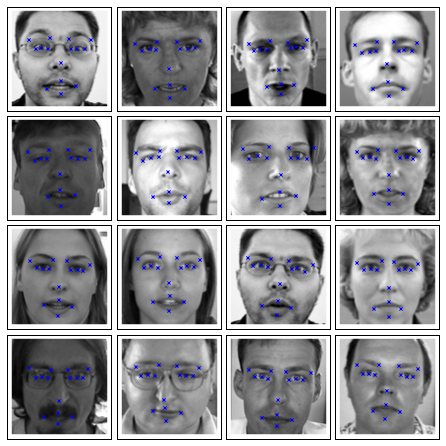

In [16]:
#prediction results
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load2d(test=True)
y_pred = net.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()

<module 'matplotlib.pyplot' from '/home/cuda/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

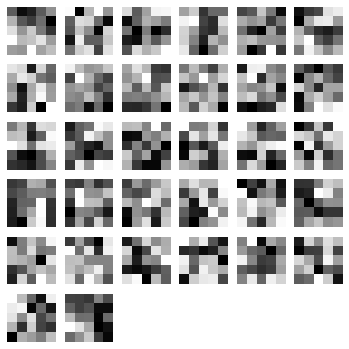

In [17]:
#visualize first layer weights
visualize.plot_conv_weights(net.layers_['conv1'])

<module 'matplotlib.pyplot' from '/home/cuda/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

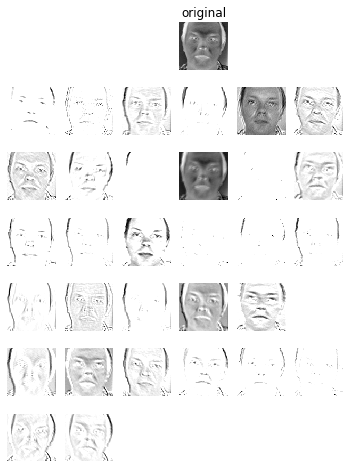

In [18]:
#visualize first layer weights
visualize.plot_conv_activity(net.layers_['conv1'], X[i:i+1, :, :, :])